## Домашнее задание

In [1]:
import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
os.makedirs('./data', exist_ok=True)

In [3]:
# архитектура модели
# гиперпараметры
# загрузчик данных
# формирование батча
# инициализировать модель
# оптимизатор
# функция потерь
# опционально шедулеры
# трейн луп

In [4]:
# hyperparams
inp_dim = 28 * 28
hidden = 256
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}' # 'cuda:0' id GPU
n_epochs = 10
batch_size = 128

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
])

# зашружаем тренировочный сет
dataset_train = datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=transform)

# зашружаем тестовый сет
dataset_test = datasets.MNIST(
    './data',
    train=False,
    download=True,
    transform=transform)

In [6]:
dataset_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

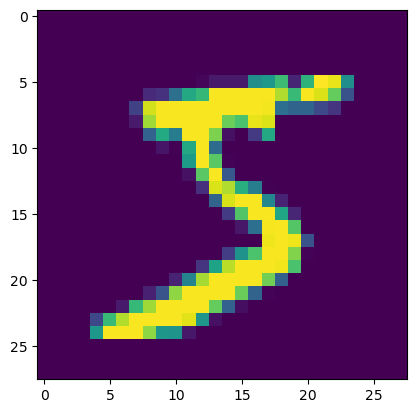

In [7]:
plt.imshow(dataset_train.data[0].detach().numpy())
plt.show()

In [8]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1):
        super().__init__()
        
        # UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
       
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        nn.init.xavier_uniform_(self.linear1.weight) # custom init
        self.do1 = nn.Dropout(dropout_p)
        
        # Добавлен скрытый слой
        self.linear2 = nn.Linear(hidden_dim, int(hidden_dim/2))
        nn.init.xavier_uniform_(self.linear2.weight) # custom init
        self.do2 = nn.Dropout(dropout_p)
        
        # Добавлен скрытый слой
        self.linear3 = nn.Linear(int(hidden_dim/2), hidden_dim)
        nn.init.xavier_uniform_(self.linear3.weight) # custom init
        self.do3 = nn.Dropout(dropout_p)
        
        self.linear4 = nn.Linear(hidden_dim, output_dim)
        
        self.activ = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activ(x)
        x = self.do1(x)
        
        x = self.linear2(x)
        x = self.activ(x)
        x = self.do2(x)
        
        x = self.linear3(x)
        x = self.activ(x)
        x = self.do3(x)
        
        x = self.linear4(x)

        return x

In [9]:
# Как формируется батч
# dataloader берет из Samler набор индексов и по этим индексам получает элементы из Dataset

# Загружаем тренировочный датасет
dataset_train = datasets.MNIST(
    './data',
    train=True,
    download=True)

# Загружаем тестовый датасет
dataset_test = datasets.MNIST(
    './data',
    train=False,
    download=True)

In [10]:
def collate_fn(data: list):
    # data = [(pic, target)...]
    pics = []
    targets = []
    for item in data:
        pics.append(numpy.array(item[0]))
        targets.append(item[1])
    pics = torch.from_numpy(numpy.array(pics)).float() / 255
    pics = pics.view(pics.size(0), -1) # mtx 28x28 to vec 7xx
    targets = torch.from_numpy(numpy.array(targets))

    return {
        'data': pics,
        'target': targets,
    }

dataloader_train = DataLoader(
    dataset_train, 
    batch_size, 
    shuffle=True, 
    collate_fn=collate_fn,
    drop_last = True)

dataloader_test = DataLoader(
    dataset_test,
    batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=True)

In [11]:
model = LinearModel(inp_dim, hidden, out_dim).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

In [12]:
chkpt_dir = './data/chkpt/chkpt_cv1'
os.makedirs(chkpt_dir, exist_ok=True)

for epoch in range(n_epochs):
    # Обучение
    model.train()
    for i, batch in enumerate(dataloader_train):
        optim.zero_grad()
        predict = model(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()

        if i % 200 == 0:
            print(f'train: epoch: {epoch:02d}, step: {i:03d}, loss: {loss.item():.16f}')

    # Тест
    model.eval()
    total_loss = 0
    for i, batch in enumerate(dataloader_test):
        with torch.no_grad():
            predict = model(batch['data'].to(device))
            loss = loss_func(predict, batch['target'].to(device))
            total_loss += loss.item()
    total_loss /= len(dataloader_test)
    print(f' test: epoch: {epoch:02d}, step: {i:03d}, loss: {total_loss:.16f}')

    #save every epoch
    torch.save(model.state_dict(), f'{chkpt_dir}/chkpt_cv1_{epoch}.pth')

train: epoch: 00, step: 000, loss: 2.3210251331329346
train: epoch: 00, step: 200, loss: 0.2262500822544098
train: epoch: 00, step: 400, loss: 0.0856500416994095
 test: epoch: 00, step: 077, loss: 0.1327115341256826
train: epoch: 01, step: 000, loss: 0.1041648313403130
train: epoch: 01, step: 200, loss: 0.1387283504009247
train: epoch: 01, step: 400, loss: 0.1289797127246857
 test: epoch: 01, step: 077, loss: 0.0928648715265668
train: epoch: 02, step: 000, loss: 0.0450019575655460
train: epoch: 02, step: 200, loss: 0.0684034824371338
train: epoch: 02, step: 400, loss: 0.0732533857226372
 test: epoch: 02, step: 077, loss: 0.0825121402024077
train: epoch: 03, step: 000, loss: 0.0678911730647087
train: epoch: 03, step: 200, loss: 0.0559951625764370
train: epoch: 03, step: 400, loss: 0.0378405861556530
 test: epoch: 03, step: 077, loss: 0.0762931213069421
train: epoch: 04, step: 000, loss: 0.1197224259376526
train: epoch: 04, step: 200, loss: 0.0334099009633064
train: epoch: 04, step: 400,

# Новый раздел

In [13]:
# hyperparams
input_ch = 1
hidden_ch = 128
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [14]:
class ConvDO(nn.Module):
    def __init__(self, input_ch, output_ch, kernel_size, stride, padding, dropout_p=0.1):
        super().__init__()

        self.conv = nn.Conv2d(
            input_ch,
            output_ch,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding)
        # Добавим батч норм
        self.bn = nn.BatchNorm2d(output_ch)
        self.do = nn.Dropout(dropout_p)

    def forward(self, x):
        return self.do(self.bn(self.conv(x)))

class ConvModel(nn.Module):
    def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
        super().__init__()
        
        # Уменьшим размер выходной фичматрицы в 2 раза
        self.conv1 = ConvDO(input_ch, hidden_ch, 5, 2, 2)
        # Уменьшим размер выходной фичматрицы в 2 раза
        self.conv2 = ConvDO(hidden_ch, hidden_ch, 5, 1, 2)
        # Фичматрицу не меняем
        self.conv3 = ConvDO(hidden_ch, hidden_ch, 3, 1, 1)
        # Увеличим число выходных каналов до 5
        self.conv4 = ConvDO(hidden_ch, 5, 3, 1, 1)
        self.linear = nn.Linear(
            5 * 14 * 14, # Размер фичматрицы с учетом изменения числа каналов
            output_dim)  
        self.activ = nn.ReLU()    

    def forward(self, x):
        x = self.activ(self.conv1(x))
        x = self.activ(self.conv2(x))
        x = self.activ(self.conv3(x))
        x = self.activ(self.conv4(x))
        x = self.linear(x.view(x.size(0), -1))

        return x

In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
])

# Загружаем тренировочный сет
dataset_train = datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=transform)

# Загружаем тестовый датасет
dataset_test = datasets.MNIST(
    './data',
    train=False,
    download=True,
    transform=transform)

In [16]:
test_loader = DataLoader(
    dataset_test, 
    batch_size=batch_size,
    shuffle=True, 
    num_workers=2, 
    drop_last=True)

train_loader = DataLoader(
    dataset_train, 
    batch_size=batch_size,
    shuffle=True, 
    num_workers=2, 
    drop_last = True)

In [17]:
model_conv = ConvModel(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.CrossEntropyLoss()

In [18]:
chkpt_dir = './data/chkpt/chkpt_cv1_conv'
os.makedirs(chkpt_dir, exist_ok=True)

for epoch in range(n_epochs):
    # Обучение
    model_conv.train()
    for i, batch in enumerate(train_loader):
        inputs, labels = batch
        optim.zero_grad()

        predict = model_conv(inputs.to(device))
        loss = loss_func(predict, labels.to(device))
        loss.backward()
        optim.step()

        if i % 200 == 0:
            print(f'train: epoch: {epoch:02d}, step: {i:03d}, loss: {loss.item():.16f}')

    # Тест
    model_conv.eval()
    total_loss = 0
    for i, batch in enumerate(test_loader):
        inputs, labels = batch
        with torch.no_grad():
            predict = model_conv(inputs.to(device))
            loss = loss_func(predict, labels.to(device))
            total_loss += loss.item()
    total_loss /= len(test_loader)
    print(f' test: epoch: {epoch:02d}, step: {i:03d}, loss: {total_loss:.16f}')

    #save every epoch
    torch.save(model_conv.state_dict(), f'{chkpt_dir}/chkpt_cv1_conv_{epoch}.pth')

train: epoch: 00, step: 000, loss: 2.3232254981994629
train: epoch: 00, step: 200, loss: 0.2254685759544373
train: epoch: 00, step: 400, loss: 0.0518436022102833
 test: epoch: 00, step: 077, loss: 0.0526582626984096
train: epoch: 01, step: 000, loss: 0.0398455038666725
train: epoch: 01, step: 200, loss: 0.0068697831593454
train: epoch: 01, step: 400, loss: 0.0272454190999269
 test: epoch: 01, step: 077, loss: 0.0295074061215975
train: epoch: 02, step: 000, loss: 0.0097483005374670
train: epoch: 02, step: 200, loss: 0.0044852574355900
train: epoch: 02, step: 400, loss: 0.0596264488995075
 test: epoch: 02, step: 077, loss: 0.0289501873388266
train: epoch: 03, step: 000, loss: 0.0043548215180635
train: epoch: 03, step: 200, loss: 0.0035075244959444
train: epoch: 03, step: 400, loss: 0.0187437366694212
 test: epoch: 03, step: 077, loss: 0.0289033503370145
train: epoch: 04, step: 000, loss: 0.0251311659812927
train: epoch: 04, step: 200, loss: 0.0283729005604982
train: epoch: 04, step: 400,